In [27]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow.keras.datasets as tfds
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B1
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
import tensorflow_addons as tfa

C:\Users\User\miniconda3\envs\tf-gpu\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\User\miniconda3\envs\tf-gpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If 

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)
tf. config. list_physical_devices('GPU') 
tf.debugging.set_log_device_placement(True)

1 Physical GPUs, 1 Logical GPUs


In [3]:
#Start module from here

In [58]:
import os
path = os.getcwd()
data_dir = path+'/Трубы/Dataset/'#png'
data_dir
#os.scandir
#from glob import glob
#glob('C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\*', recursive = True)

'D:\\0-Rojects\\2023-Atomhack/Трубы/Dataset/'

In [59]:
batch_size = 128 #32
img_height = 160
img_width = 160

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  crop_to_aspect_ratio=True,
  batch_size=batch_size)

Found 29287 files belonging to 14 classes.
Using 20501 files for training.


In [60]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 29287 files belonging to 14 classes.
Using 5857 files for validation.


In [61]:
resize_and_rescale = tf.keras.Sequential([
  layers.Rescaling(1./255)
])


In [62]:
data_augmentation = tf.keras.Sequential([
  #layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])
#aug_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [7]:
class_names = train_ds.class_names
detail_names_list = train_ds.class_names
print(class_names)


['0', '1', '10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9']


In [8]:
num_classes = len(class_names)

In [63]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [64]:
#batch_size = 128
#AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
    #ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
    #          num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

  # Batch all datasets.
        ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)


train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

ValueError: in user code:

    File "C:\Users\User\AppData\Local\Temp\ipykernel_10588\2127594077.py", line 17, in None  *
        lambda x, y: (data_augmentation(x, training=True), y)
    File "C:\Users\User\miniconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\User\miniconda3\envs\tf-gpu\lib\site-packages\keras\layers\preprocessing\image_preprocessing.py", line 444, in call
        raise ValueError(

    ValueError: Exception encountered when calling layer "random_rotation" "                 f"(type RandomRotation).
    
    Image augmentation layers are expecting inputs to be rank 3 (HWC) or 4D (NHWC) tensors. Got shape: (None, None, 160, 160, 3)
    
    Call arguments received by layer "random_rotation" "                 f"(type RandomRotation):
      • inputs=tf.Tensor(shape=(None, None, 160, 160, 3), dtype=float32)
      • training=True


In [45]:
import tensorflow as tf

def f1(y_true, y_pred):
    predLabels = K.argmax(pred, axis=-1)
    pred = K.one_hot(predLabels, 4) 
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)




In [66]:
import keras.backend as K
#tf.keras.saving.get_custom_objects().clear()
#@tf.keras.saving.register_keras_serializable(package="my_package", name="f1_weighted")
def f1_weighted(true, pred): #shapes (batch, 4)

    #for metrics include these two lines, for loss, don't include them
    #these are meant to round 'pred' to exactly zeros and ones
    predLabels = K.argmax(pred, axis=-1)
    pred = K.one_hot(predLabels, 4) 


    ground_positives = K.sum(true, axis=0) + K.epsilon()       # = TP + FN
    pred_positives = K.sum(pred, axis=0) + K.epsilon()         # = TP + FP
    true_positives = K.sum(true * pred, axis=0) + K.epsilon()  # = TP
        #all with shape (4,)
    
    precision = true_positives / pred_positives 
    recall = true_positives / ground_positives
        #both = 1 if ground_positives == 0 or pred_positives == 0
        #shape (4,)

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
        #still with shape (4,)

    weighted_f1 = f1 * ground_positives / K.sum(ground_positives) 
    weighted_f1 = K.sum(weighted_f1)

    
    return 1 - weighted_f1 #for metrics, return only 'weighted_f1'

In [67]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    #start_from_epoch=10,
    patience=4
)
model_save = tf.keras.callbacks.ModelCheckpoint(
    path,
    save_best_only = True,
)
callbacks = [early_stop,model_save]

In [69]:
epochs = 20

# create the base pre-trained model
base_model = EfficientNetV2B1(weights='imagenet', include_top=False, input_shape = (img_height, img_width, 3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),#from_logits=True
  metrics=['accuracy'])
# train the model on the new data for a few epochs
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)#, callbacks=[callbacks]

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
#for i, layer in enumerate(base_model.layers):
#    print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:198]:
    layer.trainable = False
for layer in model.layers[198:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.0001, momentum=0.9),#tf.keras.optimizers.Adam(
    #learning_rate=0.0001),#,
    #ema_momentum=0.95
    #SGD(learning_rate=0.0001, momentum=0.9), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),#from_logits=True
    metrics=['accuracy'])#metrics=['accuracy'])f1_weighted

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs, callbacks=[callbacks],
verbose = 2)

Epoch 1/20
161/161 [==============================] - 37s 169ms/step - loss: 0.8070 - accuracy: 0.7900 - val_loss: 0.6677 - val_accuracy: 0.8195
Epoch 2/20
161/161 [==============================] - 14s 86ms/step - loss: 0.6366 - accuracy: 0.8297 - val_loss: 0.6296 - val_accuracy: 0.8305
Epoch 3/20
161/161 [==============================] - 14s 85ms/step - loss: 0.5966 - accuracy: 0.8400 - val_loss: 0.6266 - val_accuracy: 0.8313
Epoch 4/20
161/161 [==============================] - 14s 85ms/step - loss: 0.5714 - accuracy: 0.8489 - val_loss: 0.6121 - val_accuracy: 0.8346
Epoch 5/20
161/161 [==============================] - 14s 86ms/step - loss: 0.5554 - accuracy: 0.8507 - val_loss: 0.6212 - val_accuracy: 0.8291
Epoch 6/20
161/161 [==============================] - 14s 87ms/step - loss: 0.5410 - accuracy: 0.8559 - val_loss: 0.6284 - val_accuracy: 0.8299
Epoch 7/20
161/161 [==============================] - 14s 87ms/step - loss: 0.5349 - accuracy: 0.8560 - val_loss: 0.6071 - val_accuracy

INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


161/161 - 76s - loss: 1.7714 - accuracy: 0.5874 - val_loss: 1.1026 - val_accuracy: 0.7159 - 76s/epoch - 471ms/step
Epoch 2/20


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


161/161 - 61s - loss: 1.0474 - accuracy: 0.7217 - val_loss: 0.9638 - val_accuracy: 0.7558 - 61s/epoch - 377ms/step
Epoch 3/20


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


161/161 - 62s - loss: 0.9329 - accuracy: 0.7542 - val_loss: 0.8917 - val_accuracy: 0.7779 - 62s/epoch - 384ms/step
Epoch 4/20


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


161/161 - 61s - loss: 0.8651 - accuracy: 0.7785 - val_loss: 0.8495 - val_accuracy: 0.7920 - 61s/epoch - 379ms/step
Epoch 5/20


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


161/161 - 61s - loss: 0.8260 - accuracy: 0.7884 - val_loss: 0.8121 - val_accuracy: 0.8023 - 61s/epoch - 378ms/step
Epoch 6/20


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


161/161 - 61s - loss: 0.7930 - accuracy: 0.7964 - val_loss: 0.7893 - val_accuracy: 0.8076 - 61s/epoch - 380ms/step
Epoch 7/20


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


161/161 - 62s - loss: 0.7594 - accuracy: 0.8048 - val_loss: 0.7651 - val_accuracy: 0.8115 - 62s/epoch - 382ms/step
Epoch 8/20


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


161/161 - 61s - loss: 0.7396 - accuracy: 0.8096 - val_loss: 0.7461 - val_accuracy: 0.8154 - 61s/epoch - 378ms/step
Epoch 9/20


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


161/161 - 61s - loss: 0.7255 - accuracy: 0.8127 - val_loss: 0.7361 - val_accuracy: 0.8180 - 61s/epoch - 380ms/step
Epoch 10/20


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


161/161 - 61s - loss: 0.7058 - accuracy: 0.8185 - val_loss: 0.7236 - val_accuracy: 0.8214 - 61s/epoch - 379ms/step
Epoch 11/20


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


161/161 - 63s - loss: 0.7001 - accuracy: 0.8190 - val_loss: 0.7105 - val_accuracy: 0.8214 - 63s/epoch - 390ms/step
Epoch 12/20


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


161/161 - 59s - loss: 0.6856 - accuracy: 0.8227 - val_loss: 0.7030 - val_accuracy: 0.8236 - 59s/epoch - 366ms/step
Epoch 13/20


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


161/161 - 63s - loss: 0.6731 - accuracy: 0.8254 - val_loss: 0.6934 - val_accuracy: 0.8243 - 63s/epoch - 393ms/step
Epoch 14/20


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


161/161 - 58s - loss: 0.6677 - accuracy: 0.8255 - val_loss: 0.6876 - val_accuracy: 0.8248 - 58s/epoch - 363ms/step
Epoch 15/20


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


161/161 - 62s - loss: 0.6590 - accuracy: 0.8286 - val_loss: 0.6853 - val_accuracy: 0.8260 - 62s/epoch - 382ms/step
Epoch 16/20


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


161/161 - 61s - loss: 0.6479 - accuracy: 0.8281 - val_loss: 0.6768 - val_accuracy: 0.8272 - 61s/epoch - 379ms/step
Epoch 17/20


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


161/161 - 61s - loss: 0.6447 - accuracy: 0.8318 - val_loss: 0.6717 - val_accuracy: 0.8272 - 61s/epoch - 382ms/step
Epoch 18/20


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


161/161 - 61s - loss: 0.6358 - accuracy: 0.8342 - val_loss: 0.6661 - val_accuracy: 0.8279 - 61s/epoch - 380ms/step
Epoch 19/20


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


161/161 - 61s - loss: 0.6301 - accuracy: 0.8345 - val_loss: 0.6653 - val_accuracy: 0.8305 - 61s/epoch - 378ms/step
Epoch 20/20


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


INFO:tensorflow:Assets written to: D:\0-Rojects\2023-Atomhack\assets


161/161 - 61s - loss: 0.6282 - accuracy: 0.8359 - val_loss: 0.6591 - val_accuracy: 0.8311 - 61s/epoch - 377ms/step


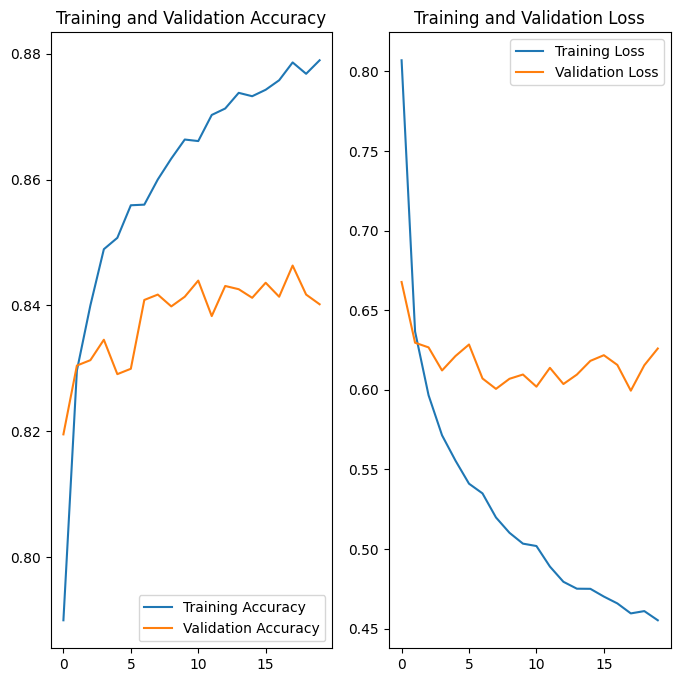

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

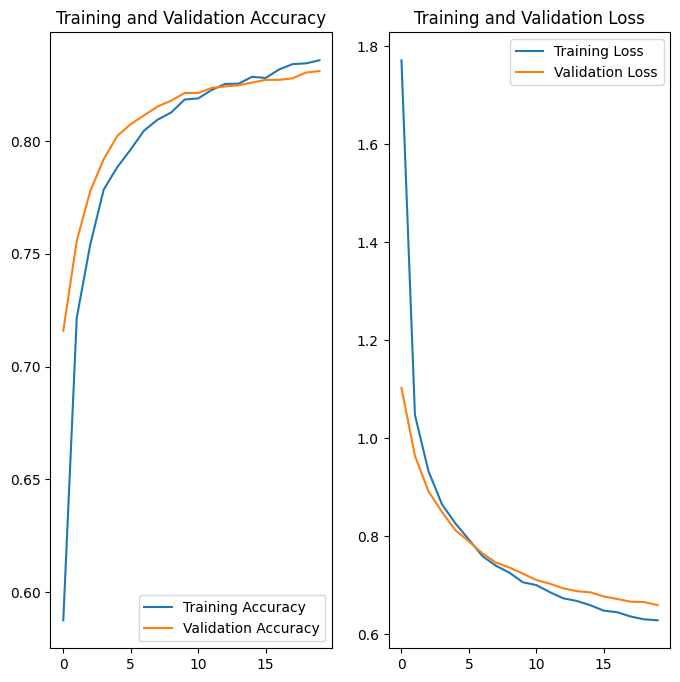

In [71]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(len(loss))#epochs

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [72]:
#model.save('C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\efficientnet_model.keras')
model.save('efficientnet_20_epochs_model.keras')

In [46]:
inf_model = tf.keras.models.load_model('efficientnet_20_epochs_model.keras')

In [23]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K

smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [56]:
path = os.getcwd()
prediction_folder = path + '\\sliced'
folder = prediction_folder + '\\*'
#os.scandir
from glob import glob
files = glob(folder, recursive = True)
#folder
files

['D:\\0-Rojects\\2023-Atomhack\\sliced\\output_file_name.jpg_0_0_300_300.png',
 'D:\\0-Rojects\\2023-Atomhack\\sliced\\output_file_name.jpg_0_240_300_540.png',
 'D:\\0-Rojects\\2023-Atomhack\\sliced\\output_file_name.jpg_0_300_300_600.png',
 'D:\\0-Rojects\\2023-Atomhack\\sliced\\output_file_name.jpg_240_0_540_300.png',
 'D:\\0-Rojects\\2023-Atomhack\\sliced\\output_file_name.jpg_240_240_540_540.png',
 'D:\\0-Rojects\\2023-Atomhack\\sliced\\output_file_name.jpg_240_300_540_600.png',
 'D:\\0-Rojects\\2023-Atomhack\\sliced\\output_file_name.jpg_480_0_780_300.png',
 'D:\\0-Rojects\\2023-Atomhack\\sliced\\output_file_name.jpg_480_240_780_540.png',
 'D:\\0-Rojects\\2023-Atomhack\\sliced\\output_file_name.jpg_480_300_780_600.png',
 'D:\\0-Rojects\\2023-Atomhack\\sliced\\output_file_name.jpg_660_0_960_300.png',
 'D:\\0-Rojects\\2023-Atomhack\\sliced\\output_file_name.jpg_660_240_960_540.png',
 'D:\\0-Rojects\\2023-Atomhack\\sliced\\output_file_name.jpg_660_300_960_600.png']

In [57]:
import timeit

start = timeit.default_timer()
files = glob(folder, recursive = True)
for image_path in files:
    image = tf.keras.utils.load_img(image_path)
    image = np.array(image)
    image = tf.image.resize(image, [img_height, img_width])
    input_arr = tf.keras.utils.img_to_array(image)
    predictions = inf_model.predict(np.array([input_arr]))#(normalized_input_arr)
    #print(predictions)
    print(image_path[image_path.rfind('\\'):], ' - ',np.argmax(predictions), '(',detail_names_list[np.argmax(predictions)],')')
    stop = timeit.default_timer()

print('Time: ', stop - start)  

1/1 [==============================] - 0s 41ms/step
\output_file_name.jpg_0_0_300_300.png  -  1 ( 1 )
1/1 [==============================] - 0s 40ms/step
\output_file_name.jpg_0_240_300_540.png  -  1 ( 1 )
1/1 [==============================] - 0s 39ms/step
\output_file_name.jpg_0_300_300_600.png  -  1 ( 1 )
1/1 [==============================] - 0s 38ms/step
\output_file_name.jpg_240_0_540_300.png  -  1 ( 1 )
1/1 [==============================] - 0s 41ms/step
\output_file_name.jpg_240_240_540_540.png  -  1 ( 1 )
1/1 [==============================] - 0s 40ms/step
\output_file_name.jpg_240_300_540_600.png  -  1 ( 1 )
1/1 [==============================] - 0s 39ms/step
\output_file_name.jpg_480_0_780_300.png  -  0 ( 0 )
1/1 [==============================] - 0s 42ms/step
\output_file_name.jpg_480_240_780_540.png  -  1 ( 1 )
1/1 [==============================] - 0s 41ms/step
\output_file_name.jpg_480_300_780_600.png  -  1 ( 1 )
1/1 [==============================] - 0s 40ms/step
\outpu